# Count Objects Crossing the Line

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/count-objects-crossing-the-line.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Feb  9 17:05:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install required packages

In [ ]:
!pip install -q ultralytics supervision==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.5/709.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.1 MB/s eta 0:00:00


## Imports

In [ ]:
import numpy as np
import supervision as sv

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

## Download video

In [ ]:
download_assets(VideoAssets.VEHICLES)

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicles.mp4"

## Read single frame from video

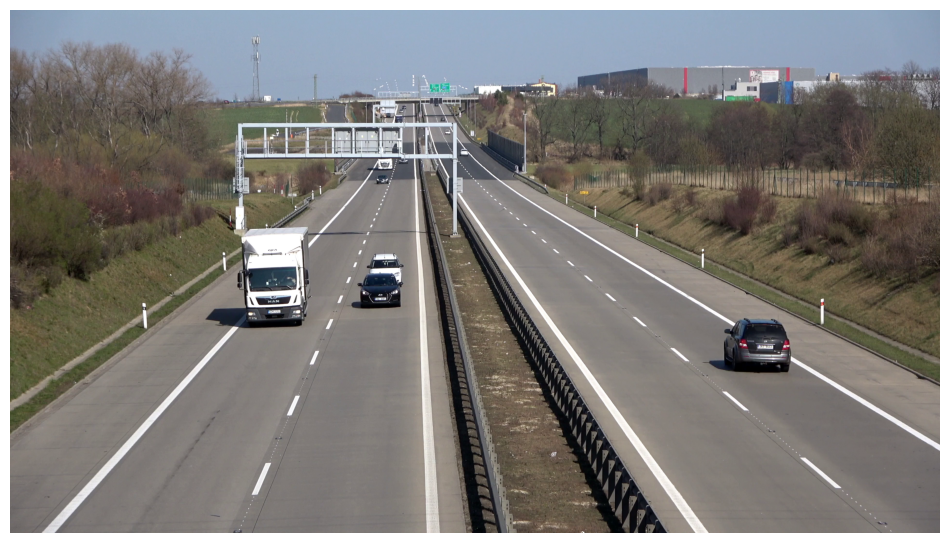

In [ ]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

## Run Object Detection

In [ ]:
model = YOLO("yolov8x.pt")

100%|██████████| 131M/131M [00:00<00:00, 159MB/s]


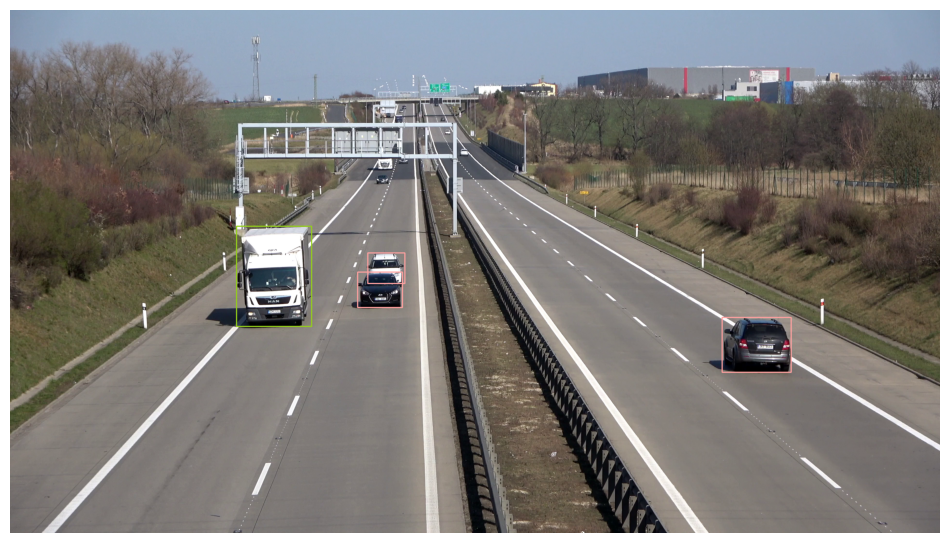

In [ ]:
results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_frame = sv.BoundingBoxAnnotator(thickness=4).annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

## Improve Vizualizations

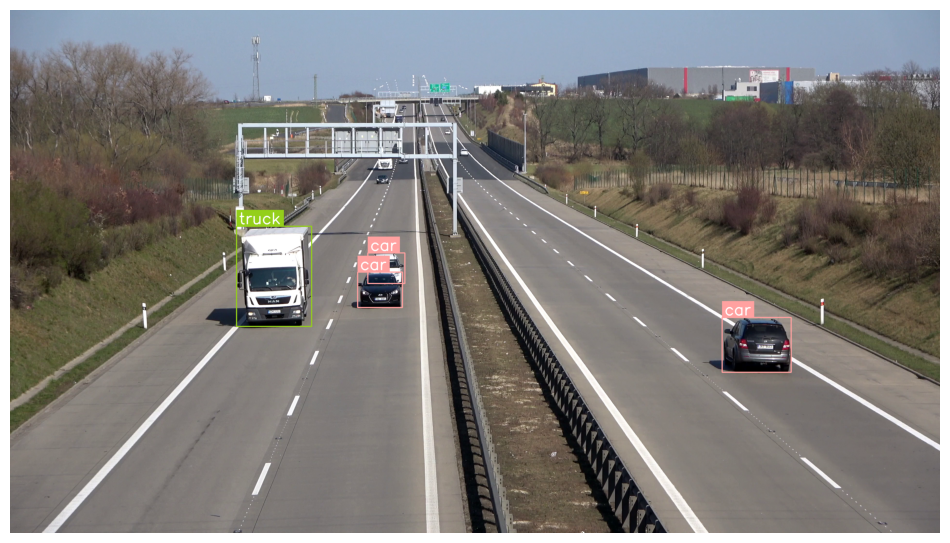

In [ ]:
results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)
labels = [results.names[i] for i in detections.class_id]

h, w, _ = frame.shape

thickness = sv.calculate_dynamic_line_thickness(resolution_wh = (w, h))
text_scale = sv.calculate_dynamic_text_scale(resolution_wh = (w, h))

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(text_thickness=thickness, text_scale=text_scale)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

## Define Line Position

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

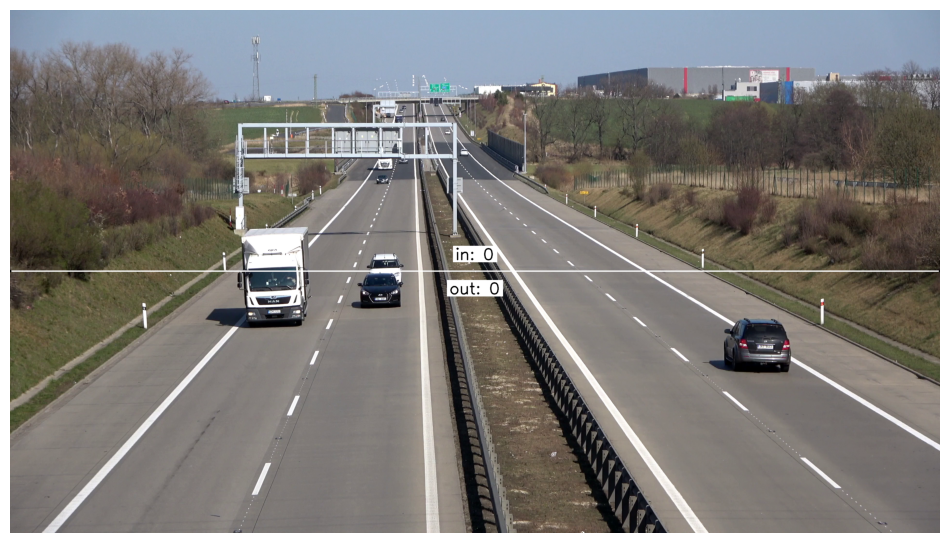

In [ ]:
START = sv.Point(0, 2160 // 2)
END = sv.Point(3840, 2160 // 2)

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=thickness,
    text_thickness=thickness,
    text_scale=text_scale)

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

## Process Video

In [ ]:
START = sv.Point(0, 1500)
END = sv.Point(3840, 1500)

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=thickness,
    text_thickness=thickness,
    text_scale=text_scale)

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [ ]:
thickness = sv.calculate_dynamic_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_dynamic_text_scale(resolution_wh=video_info.resolution_wh)

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(text_thickness=thickness, text_scale=text_scale)
trace_annotator = sv.TraceAnnotator(thickness=thickness)

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/vehicles-result.mp4"

In [ ]:
byte_tracker = sv.ByteTrack(frame_rate=video_info.fps)

In [ ]:
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    line_zone.trigger(detections)

    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [ ]:
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)